<a href="https://colab.research.google.com/github/blindTissue/NLP-Project/blob/main/narrower_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Conv-net inspired attention layers. 
# Same dimension. However, more attention heads in deeper layers.
!pip install transformers
!pip install datasets
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import math
import numpy as np


In [ ]:
dataset = load_dataset("boolq")

class BoolQADataset(torch.utils.data.Dataset):
    """
    Dataset for the dataset of BoolQ questions and answers
    """

    def __init__(self, passages, questions, answers, tokenizer, max_len):
        self.passages = passages
        self.questions = questions
        self.answers = answers
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.answers)

    def __getitem__(self, index):
        """
        This function is called by the DataLoader to get an instance of the data
        :param index:
        :return:
        """

        passage = str(self.passages[index])
        question = self.questions[index]
        answer = self.answers[index]

        # this is input encoding for your model. Note, question comes first since we are doing question answering
        # and we don't wnt it to be truncated if the passage is too long
        input_encoding = question + " [SEP] " + passage

        # encode_plus will encode the input and return a dictionary of tensors
        encoded_review = self.tokenizer.encode_plus(
            input_encoding,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors="pt",
            padding="max_length",
            truncation=True
        )

        return {
            'input_ids': encoded_review['input_ids'][0],  # we only have one example in the batch
            'attention_mask': encoded_review['attention_mask'][0],
            # attention mask tells the model where tokens are padding
            'labels': torch.tensor(answer, dtype=torch.long)  # labels are the answers (yes/no)
        }

dataset['train'][0]

dataset_train_subset = dataset['train'][:8000]
#dataset_train_subset = dataset['train'][:100]

dataset_dev_subset = dataset['validation']

max_len = 512

mytokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_dataset = BoolQADataset(
        passages=list(dataset_train_subset['passage']),
        questions=list(dataset_train_subset['question']),
        answers=list(dataset_train_subset['answer']),
        tokenizer=mytokenizer,
        max_len=max_len
)

validation_dataset = BoolQADataset(
        passages=list(dataset_dev_subset['passage']),
        questions=list(dataset_dev_subset['question']),
        answers=list(dataset_dev_subset['answer']),
        tokenizer=mytokenizer,
        max_len=max_len
    )



  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=config.pad_token_id)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    def forward(self, input_ids):
        embeddings = self.word_embeddings(input_ids)
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings
    
# set attention like convnet. braod in the beginning, then narrow down
class SelfAttention(nn.Module):
    def __init__(self, config, order):
        super().__init__()
        assert config.hidden_size % config.num_attention_heads == 0
        head_multiplier = 2 ** order

        self.num_attention_heads = config.num_attention_heads * head_multiplier
        self.attention_head_size = int(config.hidden_size / self.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        print(self.num_attention_heads, self.attention_head_size, self.all_head_size)
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)
    
    def forward(self, hidden_states):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)
        
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)

        return context_layer
    
class SelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
class Attention(nn.Module):
    def __init__(self, config, order):
        super().__init__()
        self.self = SelfAttention(config, order)
        self.output = SelfOutput(config)
    def forward(self, hidden_states):
        self_outputs = self.self(hidden_states)
        attention_output = self.output(self_outputs, hidden_states)
        return attention_output
    
class Intermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)
    def forward(self, hidden_states):
        hidden_states = self.dense(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states)
        return hidden_states
    
class Output(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.LayerNorm(hidden_states + input_tensor)
        return hidden_states
    
class Layer(nn.Module):
    def __init__(self, config, order):
        super().__init__()
        self.attention = Attention(config, order)
        self.intermediate = Intermediate(config)
        self.output = Output(config)
    def forward(self, hidden_states):
        attention_output = self.attention(hidden_states)
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)
        return layer_output

class Encoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layer = nn.ModuleList([Layer(config, order) for order in range(config.num_hidden_layers)])
    def forward(self, hidden_states):
        for layer_module in self.layer:
            hidden_states = layer_module(hidden_states)
        return hidden_states
    
class Pooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()
    def forward(self, hidden_states):
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output
    
class AttentionModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embeddings = Embeddings(config)
        self.encoder = Encoder(config)
        self.pooler = Pooler(config)
    def forward(self, input_ids, attention_mask=None):
        embedding_output = self.embeddings(input_ids)
        encoder_outputs = self.encoder(embedding_output)
        pooled_output = self.pooler(encoder_outputs)
        return encoder_outputs, pooled_output
    
    
class BinaryClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attentionModel = AttentionModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, 1)
    def forward(self, input_ids):
        _, pooled_output = self.attentionModel(input_ids)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        return logits


        


In [ ]:
from transformers import BertConfig
config = BertConfig()
print(config)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [ ]:
#make a class same as bertConfig

class Config():
    def __init__(self, attention_probs_dropout_prob = 0.1,
                 classifier_dropout = None,
                 hidden_act = "gelu",
                 hidden_dropout_prob = 0.1,
                 hidden_size = 768,
                 initializer_range = 0.02,
                 intermediate_size = 3072,
                 layer_norm_eps = 1e-12,
                 max_position_embeddings = 512,
                 model_type = "bert",
                 num_attention_heads = 12,
                 num_hidden_layers = 12,
                 pad_token_id = 0,
                 position_embedding_type = "absolute",
                 transformers_version = "4.27.3",
                 type_vocab_size = 2,
                 use_cache = True,
                 vocab_size = 30522):
        self.attention_probs_dropout_prob = attention_probs_dropout_prob
        self.classifier_dropout = classifier_dropout
        self.hidden_act = hidden_act
        self.hidden_dropout_prob = hidden_dropout_prob
        self.hidden_size = hidden_size
        self.initializer_range = initializer_range
        self.intermediate_size = intermediate_size
        self.layer_norm_eps = layer_norm_eps
        self.max_position_embeddings = max_position_embeddings
        self.model_type = model_type
        self.num_attention_heads = num_attention_heads
        self.num_hidden_layers = num_hidden_layers
        self.pad_token_id = pad_token_id
        self.position_embedding_type = position_embedding_type
        self.transformers_version = transformers_version
        self.type_vocab_size = type_vocab_size
        self.use_cache = use_cache
        self.vocab_size = vocab_size

config = Config()
config.num_hidden_layers = 5

In [ ]:
from tqdm import tqdm
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    count = 0
    for d in tqdm(data_loader):
        count += 1
        input_ids = d["input_ids"].to(device)
        labels = d["labels"].to(device)
        #print(labels)
        outputs = torch.sigmoid(model(input_ids=input_ids))
        # Calculate the predictions by thresholding at 0.5
        preds = (outputs > 0.5).float()

        # Use binary cross-entropy loss for binary classification
        loss = loss_fn(outputs, labels.unsqueeze(1).float())
        correct_predictions += torch.sum(preds == labels.unsqueeze(1))
        optimizer.zero_grad()
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
    return correct_predictions.cpu().double() / n_examples, np.mean(losses)

from torch.optim import AdamW
from transformers import get_scheduler


def evaluate(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            labels = d["labels"].to(device)
            outputs = torch.sigmoid(model(input_ids=input_ids))
            preds = (outputs > 0.5).float()
            loss = loss_fn(outputs, labels.unsqueeze(1).float())
            correct_predictions += torch.sum(preds == labels.unsqueeze(1))
            losses.append(loss.item())
    
    return correct_predictions.cpu().double() / n_examples, np.mean(losses)

def train(model, train_data_loader, val_data_loader, loss_fn, optimizer, device, scheduler, n_examples_train, n_examples_val, n_epochs):
    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        print("-" * 10)

        train_accuracy, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, n_examples_train)
        val_accuracy, val_loss = evaluate(model, val_data_loader, loss_fn, device, n_examples_val)

        train_accuracies.append(train_accuracy)
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_losses.append(val_loss)

        print(f"Train Accuracy: {train_accuracy:.4f}, Train Loss: {train_loss:.4f}")
        print(f"Val Accuracy: {val_accuracy:.4f}, Val Loss: {val_loss:.4f}")

    return {
        "train_accuracies": train_accuracies,
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "val_losses": val_losses
    }


In [ ]:
train_dataloader = DataLoader(train_dataset, 16)
validation_dataloader = DataLoader(validation_dataset, 32)

print(len(train_dataloader))
print(len(validation_dataloader))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = BinaryClassification(config).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 20
num_training_steps = epochs * len(train_dataloader)
loss_fn = nn.BCELoss().to(device)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

history = train(model, train_dataloader, validation_dataloader, loss_fn, optimizer, device, lr_scheduler, 8000, 103 * 32, epochs)

500
103
12 64 768
24 32 768
48 16 768
96 8 768
192 4 768
Epoch 1/10
----------


100%|██████████| 500/500 [02:31<00:00,  3.30it/s]


Train Accuracy: 0.6058, Train Loss: 0.6755
Val Accuracy: 0.6168, Val Loss: 0.6953
Epoch 2/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.6180, Train Loss: 0.6662
Val Accuracy: 0.6165, Val Loss: 0.6673
Epoch 3/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.6408, Train Loss: 0.6412
Val Accuracy: 0.6232, Val Loss: 0.6748
Epoch 4/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.6646, Train Loss: 0.6170
Val Accuracy: 0.6317, Val Loss: 0.6735
Epoch 5/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.6825, Train Loss: 0.5959
Val Accuracy: 0.6171, Val Loss: 0.7224
Epoch 6/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.7083, Train Loss: 0.5736
Val Accuracy: 0.6204, Val Loss: 0.7891
Epoch 7/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.7298, Train Loss: 0.5532
Val Accuracy: 0.6283, Val Loss: 0.7526
Epoch 8/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.7499, Train Loss: 0.5253
Val Accuracy: 0.6359, Val Loss: 0.7648
Epoch 9/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.7759, Train Loss: 0.4940
Val Accuracy: 0.6302, Val Loss: 0.7910
Epoch 10/10
----------


100%|██████████| 500/500 [02:30<00:00,  3.33it/s]


Train Accuracy: 0.7947, Train Loss: 0.4575
Val Accuracy: 0.6138, Val Loss: 0.7856


In [ ]:
print(history)

{'train_accuracies': [tensor(0.6058, dtype=torch.float64), tensor(0.6180, dtype=torch.float64), tensor(0.6408, dtype=torch.float64), tensor(0.6646, dtype=torch.float64), tensor(0.6825, dtype=torch.float64), tensor(0.7083, dtype=torch.float64), tensor(0.7298, dtype=torch.float64), tensor(0.7499, dtype=torch.float64), tensor(0.7759, dtype=torch.float64), tensor(0.7947, dtype=torch.float64)], 'train_losses': [0.6755166862010956, 0.6662065300345421, 0.6411980153918266, 0.6170006275773049, 0.5959270625710488, 0.5735521031022072, 0.5532474359571934, 0.5253164547681809, 0.4940330799818039, 0.4575321371555328], 'val_accuracies': [tensor(0.6168, dtype=torch.float64), tensor(0.6165, dtype=torch.float64), tensor(0.6232, dtype=torch.float64), tensor(0.6317, dtype=torch.float64), tensor(0.6171, dtype=torch.float64), tensor(0.6204, dtype=torch.float64), tensor(0.6283, dtype=torch.float64), tensor(0.6359, dtype=torch.float64), tensor(0.6302, dtype=torch.float64), tensor(0.6138, dtype=torch.float64)],

In [ ]:
print(history['train_accuracies'])

result = [tensor.item() for tensor in history['train_accuracies']]
print(type(result[0]))
print(result)

[tensor(0.6058, dtype=torch.float64), tensor(0.6180, dtype=torch.float64), tensor(0.6408, dtype=torch.float64), tensor(0.6646, dtype=torch.float64), tensor(0.6825, dtype=torch.float64), tensor(0.7083, dtype=torch.float64), tensor(0.7298, dtype=torch.float64), tensor(0.7499, dtype=torch.float64), tensor(0.7759, dtype=torch.float64), tensor(0.7947, dtype=torch.float64)]
<class 'float'>
[0.60575, 0.618, 0.64075, 0.664625, 0.6825, 0.70825, 0.72975, 0.749875, 0.775875, 0.79475]


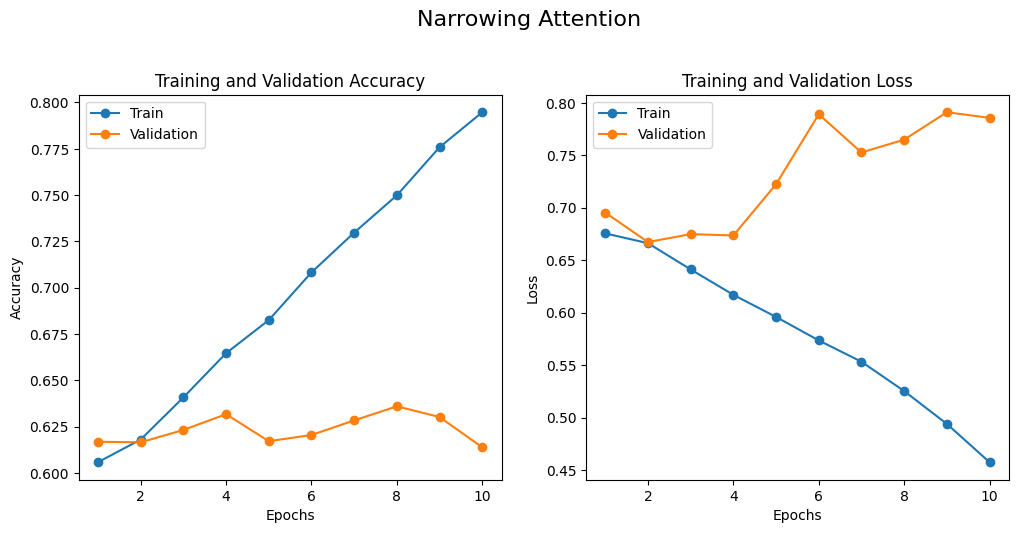

In [ ]:

import matplotlib.pyplot as plt

def plot_metrics(history):
    train_accuracies = history['train_accuracies']
    train_losses = history['train_losses']
    val_accuracies = history['val_accuracies']
    val_losses = history['val_losses']
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(12, 5))

    plt.suptitle('Narrowing Attention', fontsize=16, y=1.05)
    # Plot accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracies, label='Train', marker='o')
    plt.plot(epochs, val_accuracies, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Plot losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train', marker='o')
    plt.plot(epochs, val_losses, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_metrics(history)